# 0.0 Imports

In [29]:
import pandas as pd
import inflection
import math
import seaborn as sns
import numpy as np 
import matplotlib
import warnings
from matplotlib import pyplot as plt
import datetime
from tabulate import tabulate
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy
import xgboost as xgb
import random
import pickle
import requests


warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [30]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [17, 10]
    sns.set()
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k  = cm.shape
    chi2 = ss.chi2_contingency(cm) [0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr= r-(r-1)**2/(n-1)
    return np.sqrt ((chi2/n) / (min(k -1, r-1))) 

def ml_error (model_name, y, yhat):
    mae=mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error(y,yhat)
    rmse=np.sqrt (mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name,model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed (range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)


        #filtering dataset
        training = x_training [x_training ['date'] < validation_start_date]
        validation = x_training [(x_training ['date'] >= validation_start_date) & (x_training ['date'] <= validation_end_date) ]
 
        #training and validation dataset
        #training 
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']
        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
    
        #store performace of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model Name':model_name,
                         'MAE CV':np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV':np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV':np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])
    
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat )/ y))


def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)
    
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data


In [31]:
df_sales_raw = pd.read_csv('/home/andressasantos/Documents/comunidade_ds/ds_producao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/home/andressasantos/Documents/comunidade_ds/ds_producao/data/store.csv', low_memory = False)


#merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store' )



# 1.0 Descricao dos dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_old= ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions 

In [6]:
print('number of Rows: {}'. format (df1.shape[0]))
print('number of Collumns: {}'. format (df1.shape[1]))


number of Rows: 1017209
number of Collumns: 18


## 1.3 Data Types

In [7]:
df1['date']= pd.to_datetime (df1['date'])


## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year  

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

                            
#promo2_since_week    
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year  

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10: 'Oct', 11: 'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo']  = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                              if x['month_map'] in x['promo_interval']. split (',') else 0, axis=1)

In [11]:
df1.sample(8).T.reset_index()

,index,672201,869004,861730,54823,124895,995979,942133,104389
0,store,642,90,621,189,16,1070,744,695
1,day_of_week,3,1,1,5,5,7,6,3
2,date,2013-11-06 00:00:00,2013-05-13 00:00:00,2013-05-20 00:00:00,2015-06-12 00:00:00,2015-04-10 00:00:00,2013-01-20 00:00:00,2013-03-09 00:00:00,2015-04-29 00:00:00
3,sales,4191,9916,0,7305,7371,0,6975,7997
4,customers,541,1202,0,693,812,0,820,638
5,open,1,1,0,1,1,0,1,1
6,promo,1,1,0,0,0,0,0,1
7,state_holiday,0,0,a,0,0,0,0,0
8,school_holiday,0,0,0,0,1,0,0,0
9,store_type,c,a,a,d,a,c,a,a


## 1.6 Changes Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [14]:

num_attributes = df1.select_dtypes (include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64', 'datetime64[ns]'])

### Numerical Atributes Statistical

In [15]:
# Central Tendency - means, median
ct1 = pd.DataFrame(num_attributes.apply (np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply (np.median)).T

# Dispersion - std, min, max, range, skev, kurtosis

d1 = pd.DataFrame(num_attributes.apply (np.std)).T
d2 = pd.DataFrame(num_attributes.apply (min)).T
d3 = pd.DataFrame(num_attributes.apply (max)).T
d4 = pd.DataFrame(num_attributes.apply (lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply (lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply (lambda x: x.kurtosis() )).T

#concatenate
#m = pd.concat ([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
#m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis'] 

In [16]:
m = num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index()

In [17]:
m.sample(6)

,index,mean,median,std,min,max,skew,kurtosis
11,promo2_since_week,23.619033,22.0,14.310064,1.0,52.0,0.178723,-1.184046
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
13,is_promo,0.161100,0.0,0.367623,0.0,1.0,1.843742,1.399388
10,promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

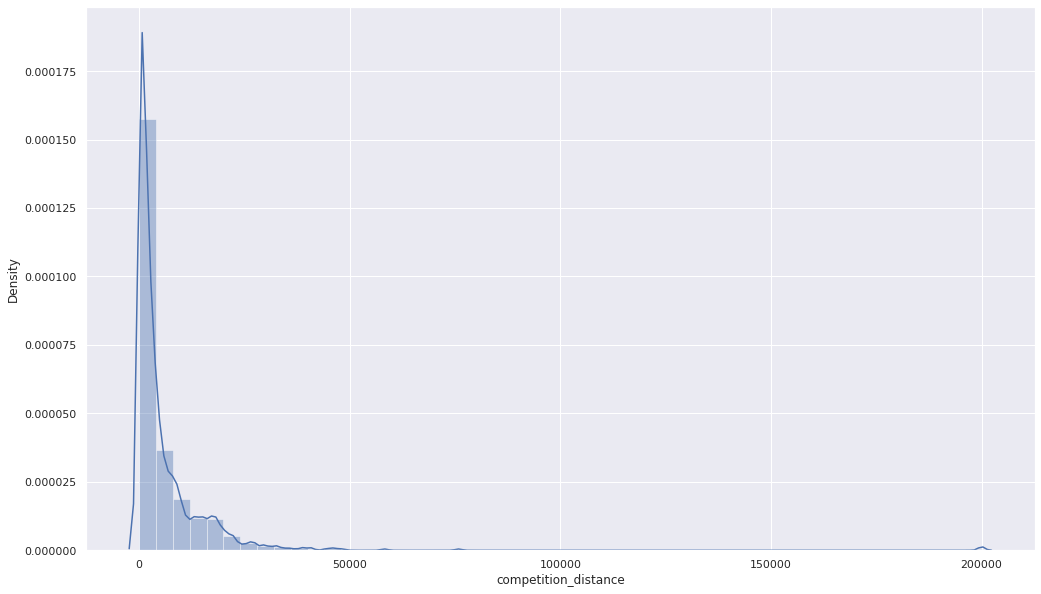

In [18]:
sns.distplot( df1['competition_distance'])

### Categorical Attributes

In [19]:
cat_attributes.apply (lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

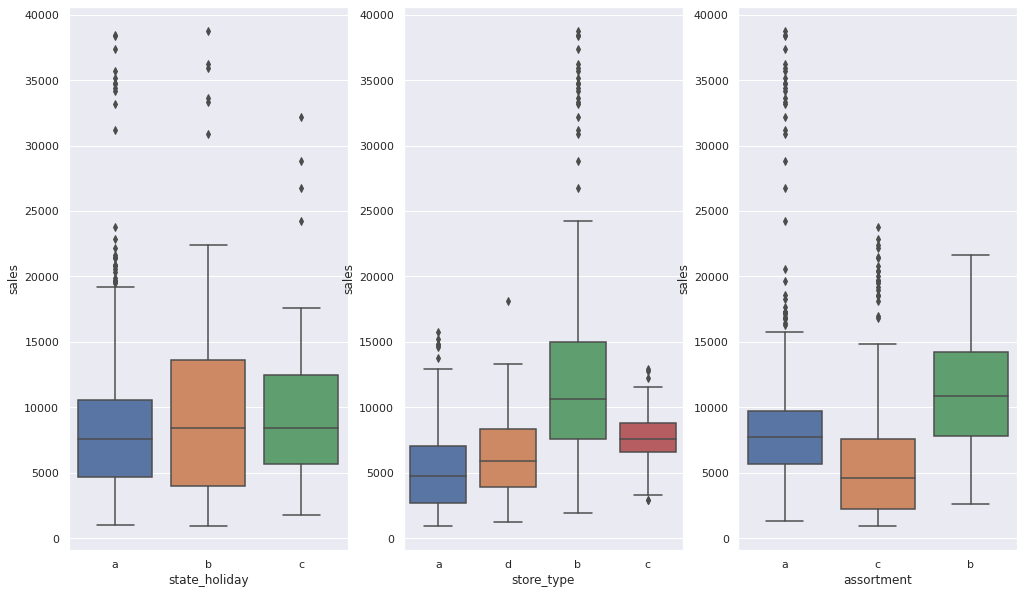

In [20]:
aux1 = df1 [(df1['state_holiday']!='0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)

sns.boxplot(x='state_holiday', y='sales', data= aux1)

plt.subplot(1, 3, 2)

sns.boxplot(x='store_type', y='sales', data= aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data= aux1)

# 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

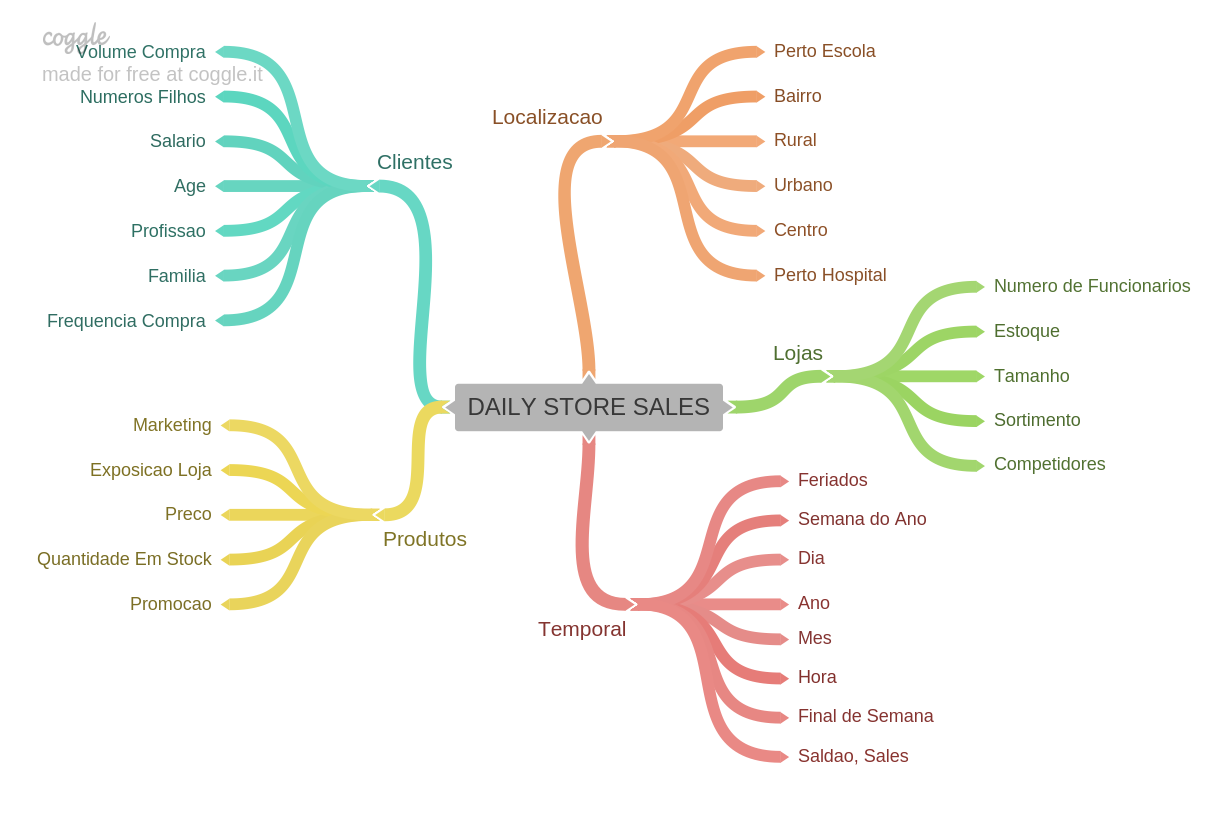

## 2.2 Criacao das Hipoteses

###  2.2.1 Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses do Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hipoteses Final

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [22]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition_since
df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis = 1)
df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

#promo_since
df2 ['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2 ['promo_since'].apply (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))

df2['promo_time_week'] = (((df2['date'] - df2['promo_since'])/7). apply (lambda x: x.days).astype(int))

#assortment
df2['assortment'] = df2['assortment'].apply (lambda x: 'basic'if x== 'a' else 'extra' if x== 'b' else 'extended')


#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday'if x== 'a' else 'easter_holiday' if x== 'b' else 'christmas'if x== 'c' else 'regular_day')



In [23]:
df2.head().T.reset_index()

,index,0,1,2,3,4
0,store,1,2,3,4,5
1,day_of_week,5,5,5,5,5
2,date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
3,sales,5263,6064,8314,13995,4822
4,customers,555,625,821,1498,559
5,open,1,1,1,1,1
6,promo,1,1,1,1,1
7,state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
8,school_holiday,1,1,1,1,1
9,store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [26]:
df3 = df3 [(df3['open'] !=0 ) & (df3 ['sales'] >0)]

## 3.2 Filtragem das colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos dados

In [31]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response variables

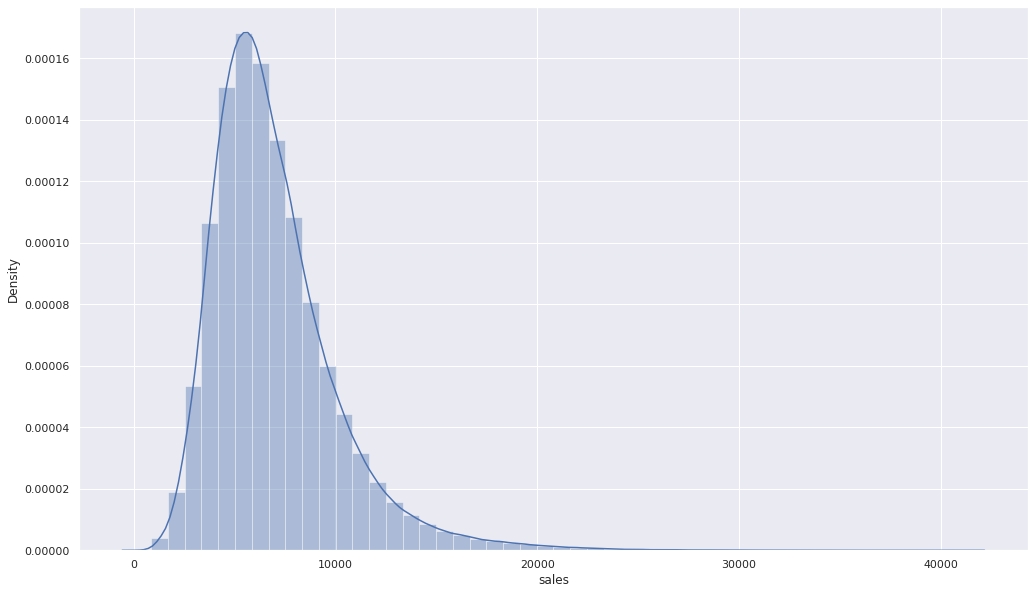

In [32]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical variables

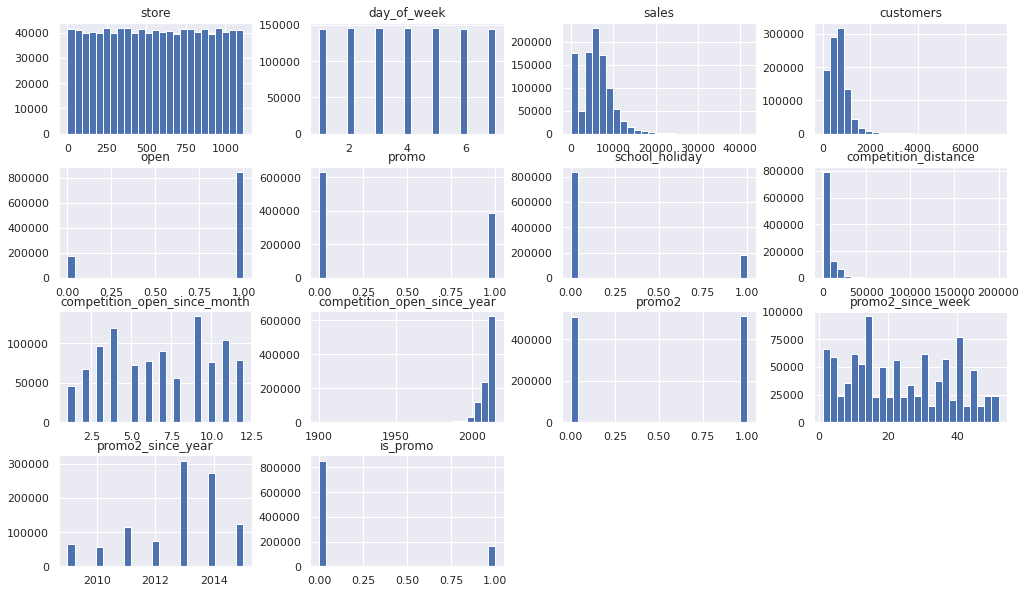

In [33]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical variables

<AxesSubplot:xlabel='sales', ylabel='Density'>

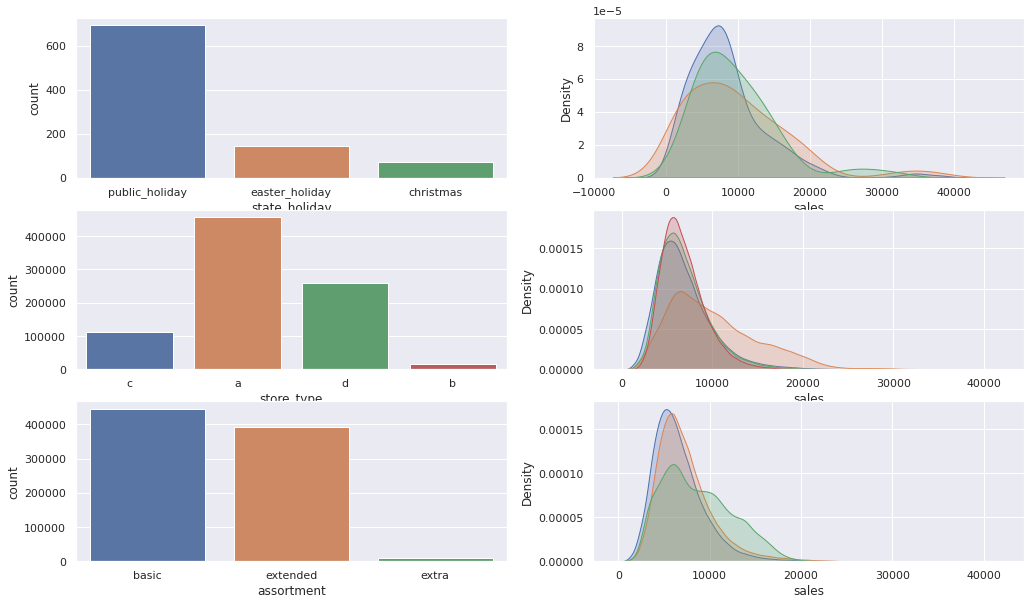

In [34]:
#state_holiday

plt.subplot(3,2,1,);
a= df4 [df4['state_holiday'] != 'regular_day']
sns.countplot (a ['state_holiday'])

plt.subplot(3,2,2,);
sns. kdeplot (df4 [df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)

sns. kdeplot (df4 [df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)

sns. kdeplot (df4 [df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)


#store_type
plt.subplot(3,2,3,);

sns.countplot (df4 ['store_type'])

plt.subplot(3,2,4);
sns. kdeplot (df4 [df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

#assortment

plt.subplot(3,2,5,);
sns.countplot (df4 ['assortment'])

plt.subplot(3,2,6);
sns. kdeplot (df4 [df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns. kdeplot (df4 [df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns. kdeplot (df4 [df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)



## 4.2 Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

#FALSA: Lojas com maior(extra) sortimentos vedem menos (insight/ dois tipos de comportamento )


<AxesSubplot:xlabel='year_week'>

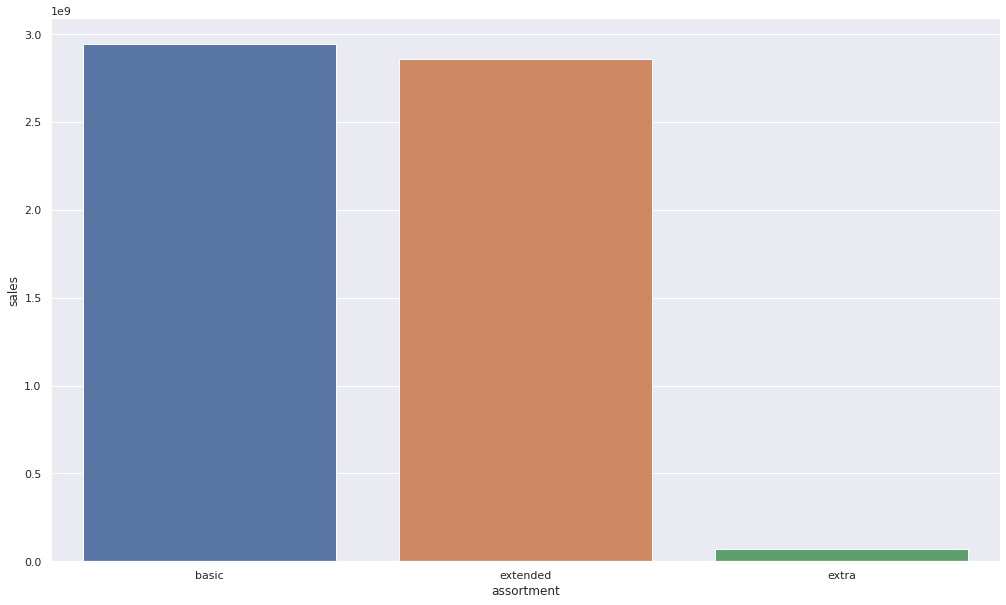

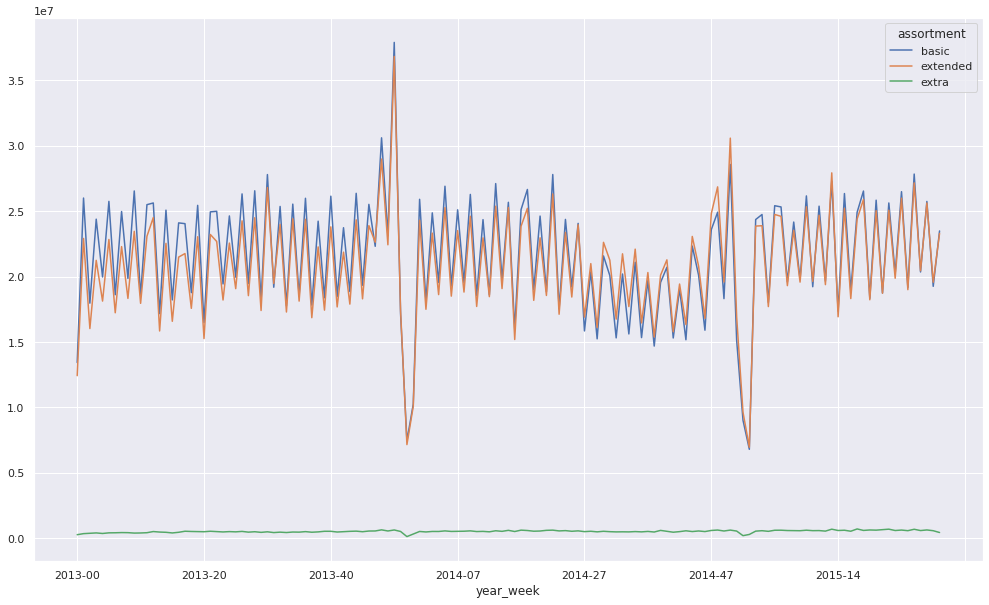

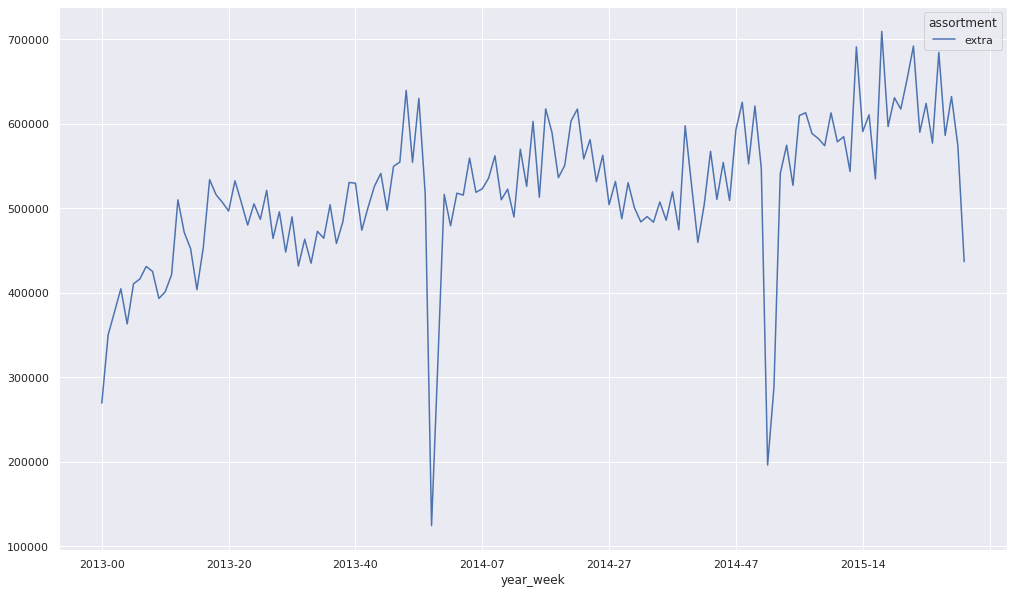

In [35]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);


aux2 = df4[['year_week','assortment', 'sales']].groupby (['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values ='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values ='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

#Falsa: Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.(insight)

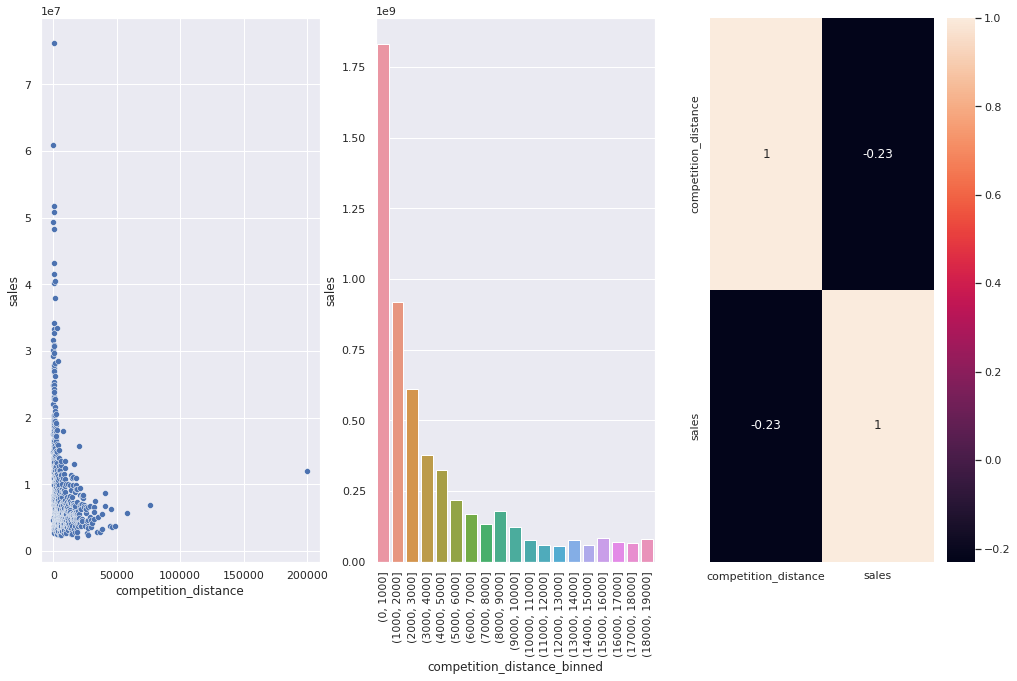

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby ('competition_distance').sum().reset_index()


plt.subplot(1,3,1)
sns.scatterplot (x = 'competition_distance', y = 'sales', data=aux1);

plt.subplot(1,3,2)
bins = list (np.arange(0,20000,1000))
aux1['competition_distance_binned']  = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby ('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y= 'sales', data=aux2);
plt.xticks (rotation = 90 )

#coleção fraca
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [37]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
11,130.0,15259085,"(0, 1000]"
23,250.0,76259307,"(0, 1000]"
569,17290.0,3668097,"(17000, 18000]"
584,18620.0,5687084,"(18000, 19000]"
424,7550.0,3443958,"(7000, 8000]"


### H3. Lojas com competidores à mais tempo deveriam vendem mais.
#Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

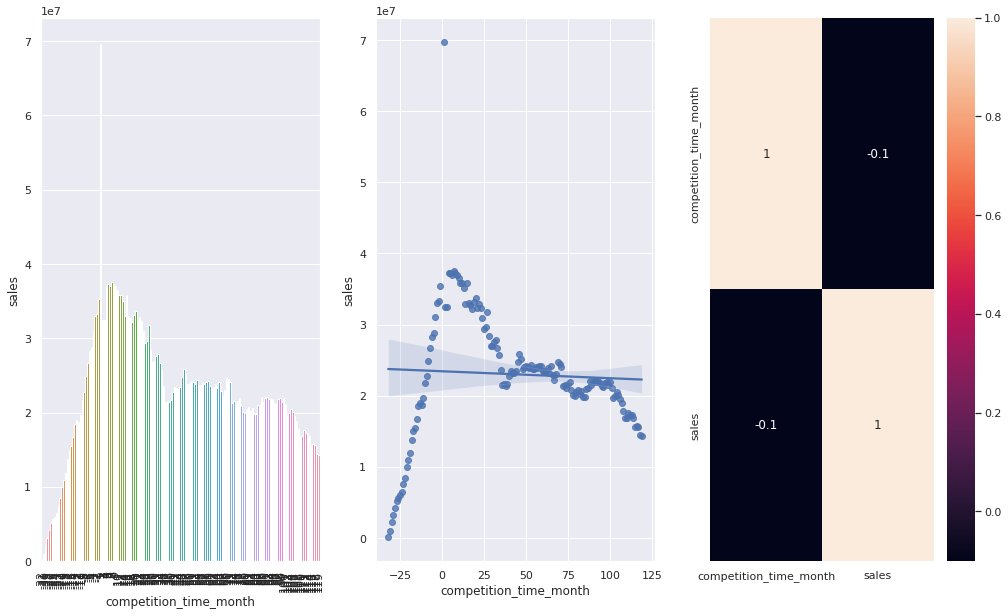

In [38]:
plt.subplot(1,3,1)
aux1= (df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index())
aux2 = aux1 [(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] !=0)]
plt.xticks (rotation = 90 )
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,2)
sns.regplot (x='competition_time_month', y='sales', data=aux2)

#corelação fraca
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

#Falsa:Lojas com promoções ativas pos mais tempo vandem menos, depois de um certo periodo de promoções


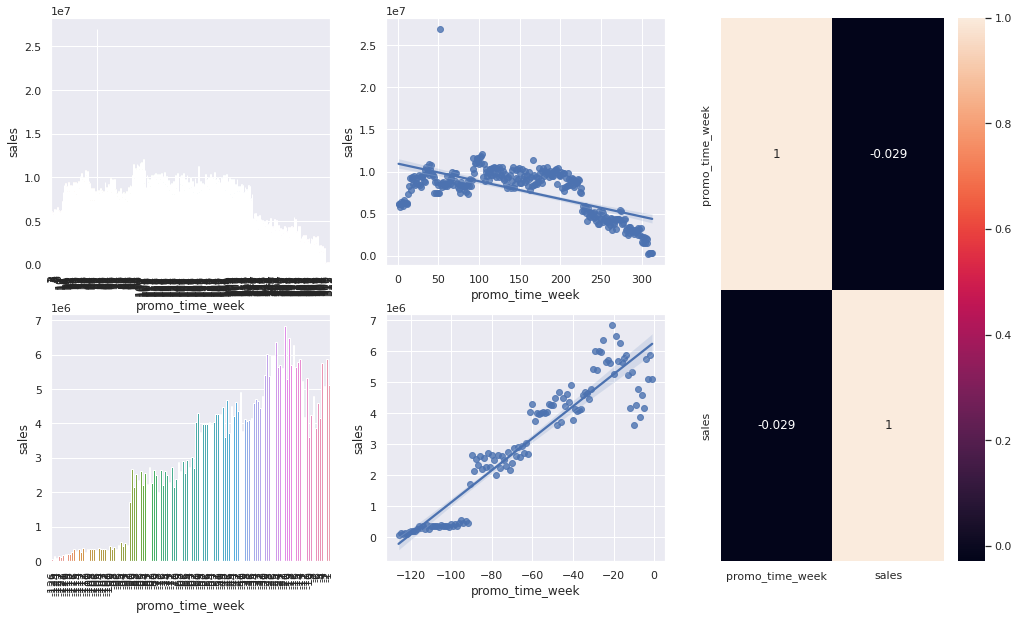

In [39]:
aux1 = (df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index())

grid = GridSpec(2,3)


plt.subplot(grid[0,0])
aux2 = aux1 [aux1['promo_time_week'] >0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks (rotation = 90 );


plt.subplot(grid[0,1])
sns.regplot (x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1 [aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks (rotation = 90 );


plt.subplot(grid[1,1])
sns.regplot (x='promo_time_week', y='sales', data=aux3);


#corelacao muito fraca
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s

  

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
#Falsa: Lojas com mais promoções consecutivas vedem menos.(insight)

In [40]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


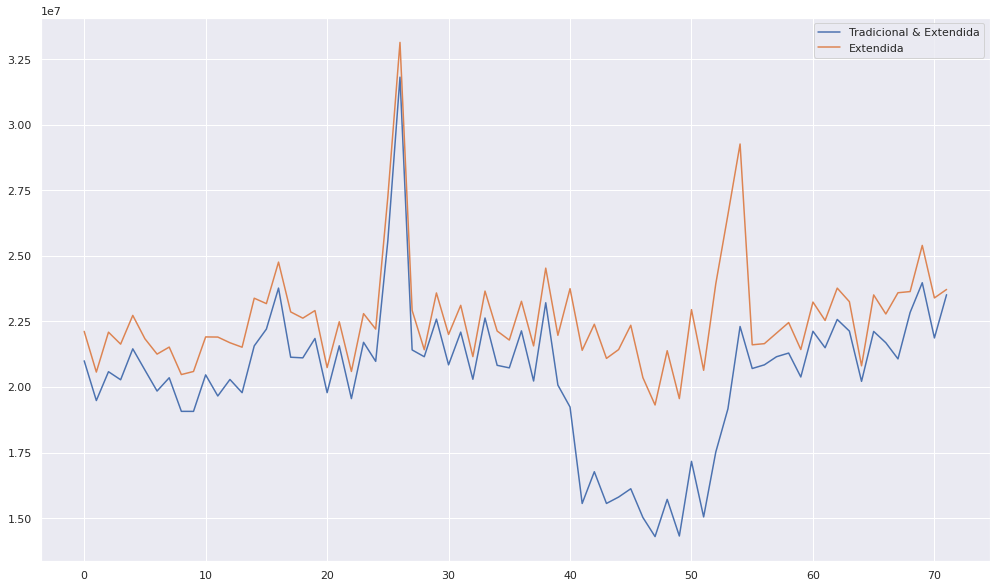

In [41]:
aux1 = df4 [(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4 [(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend (labels = ['Tradicional & Extendida', 'Extendida']) 
#revelancia para o modelo pequena


### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
#FALSA Lojas abertas durante o feriado do Natal vendem menos.


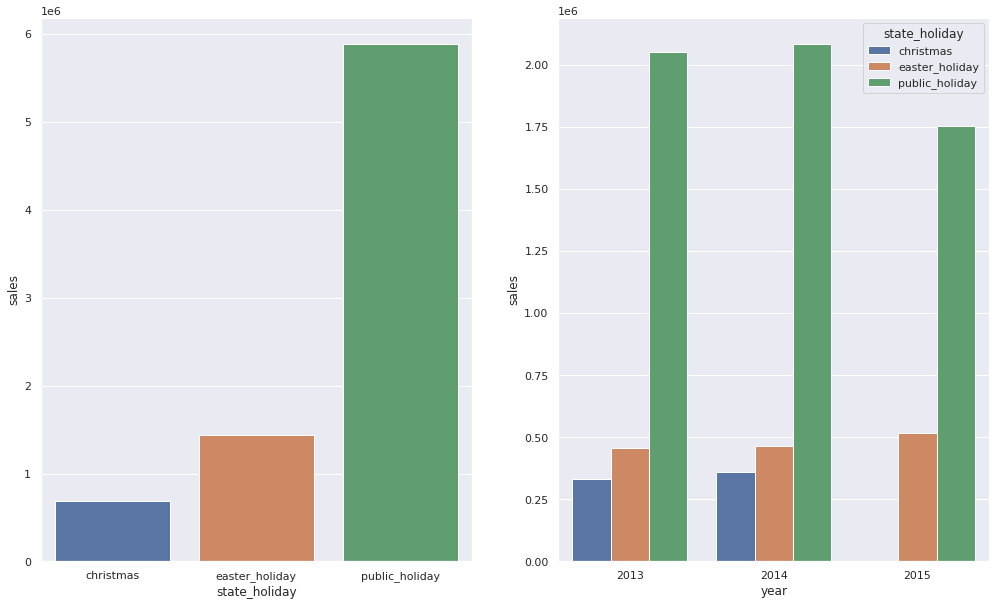

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
#revelante para o modelo

### H8. Lojas deveriam vender mais ao longo dos anos.
#Falsa lojas vedem menos ao longo dos anos


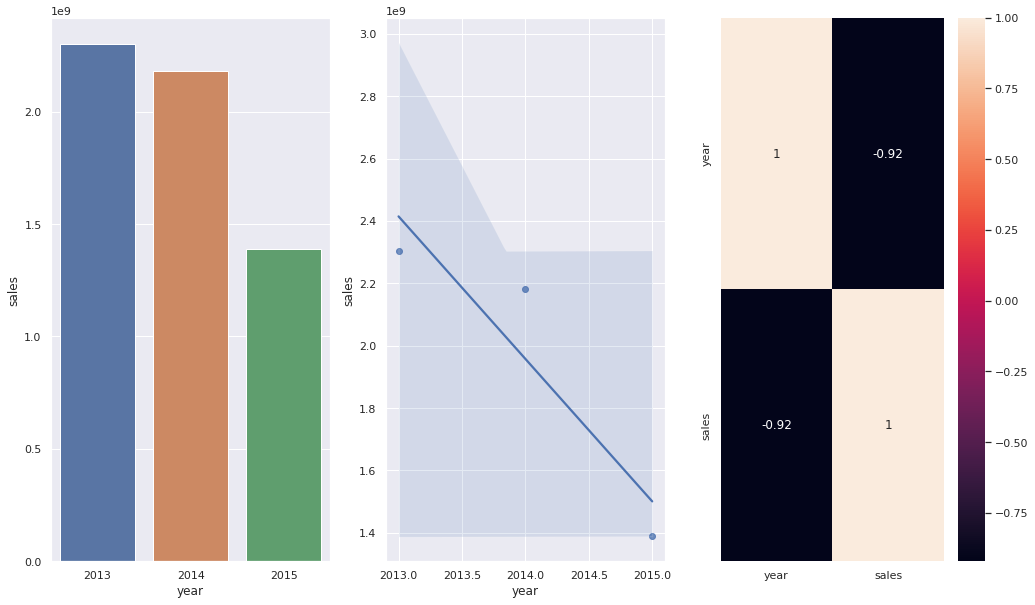

In [43]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

#tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
#corelacao muito forte(ano aberto)
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
#Falsa:Lojas vedem menos no segunda semestre do ano


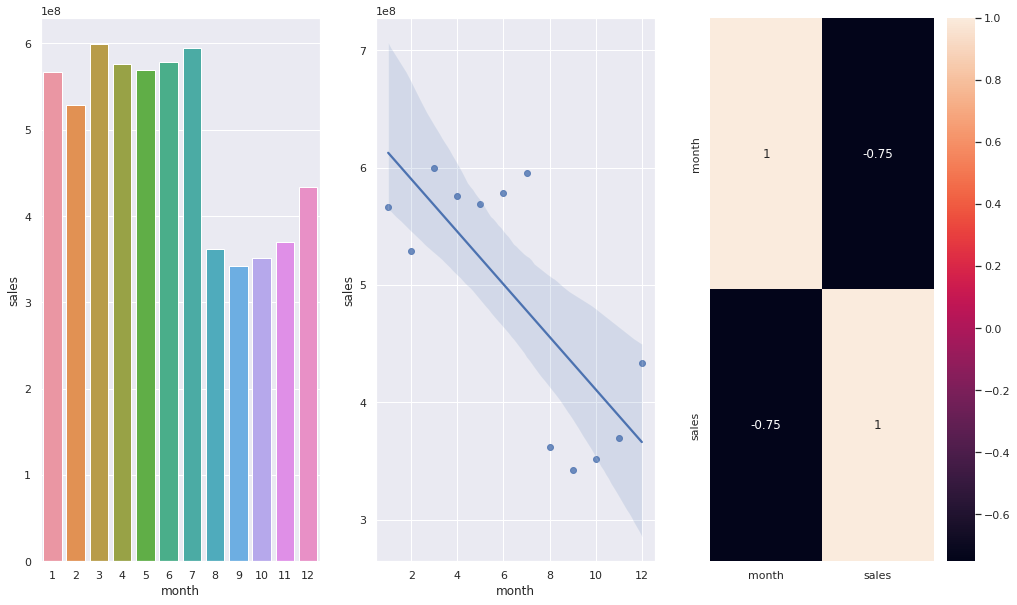

In [44]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

#tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
#corelacao muito forte
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
#verdadeira: lojas vende mais depois do dia 10 de cada mes.

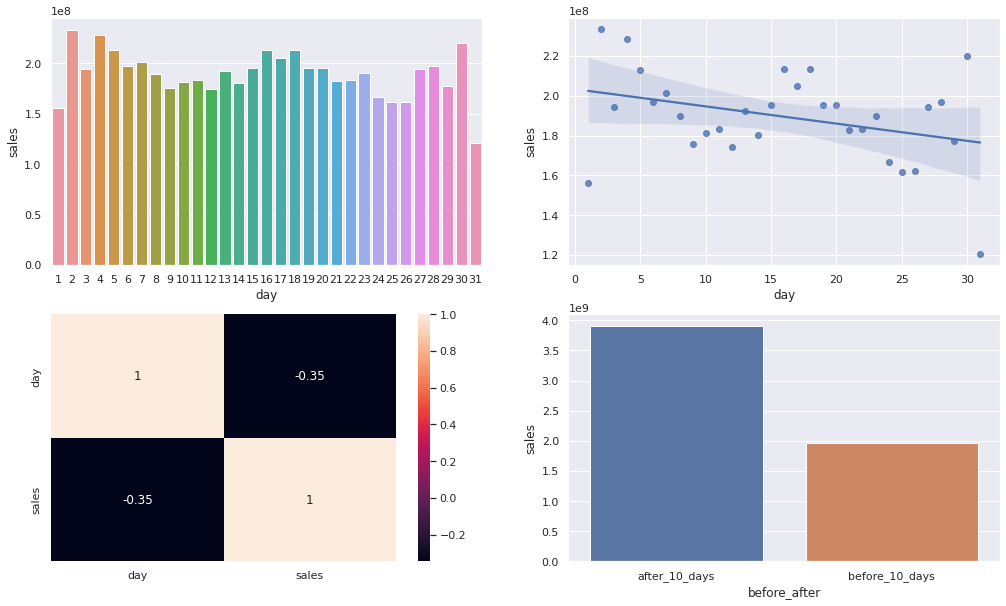

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

#tendencia
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
#corelacao muito forte
plt.subplot( 2, 2, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after').sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );






### H11. Lojas deveriam vender menos aos finais de semana.
Verdadeira:lojas vedem menos aos finais de semana






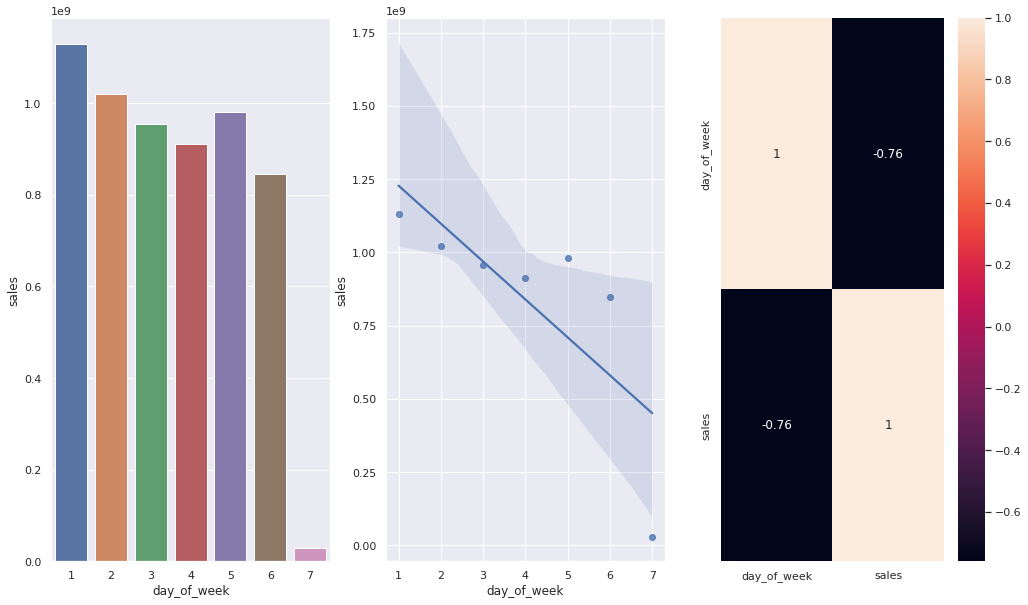

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );


plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
#corelacao forte
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
#Verdadeira:lojas vendem menos durante os feriados escolares, exeto os mesmo de julho e agosto

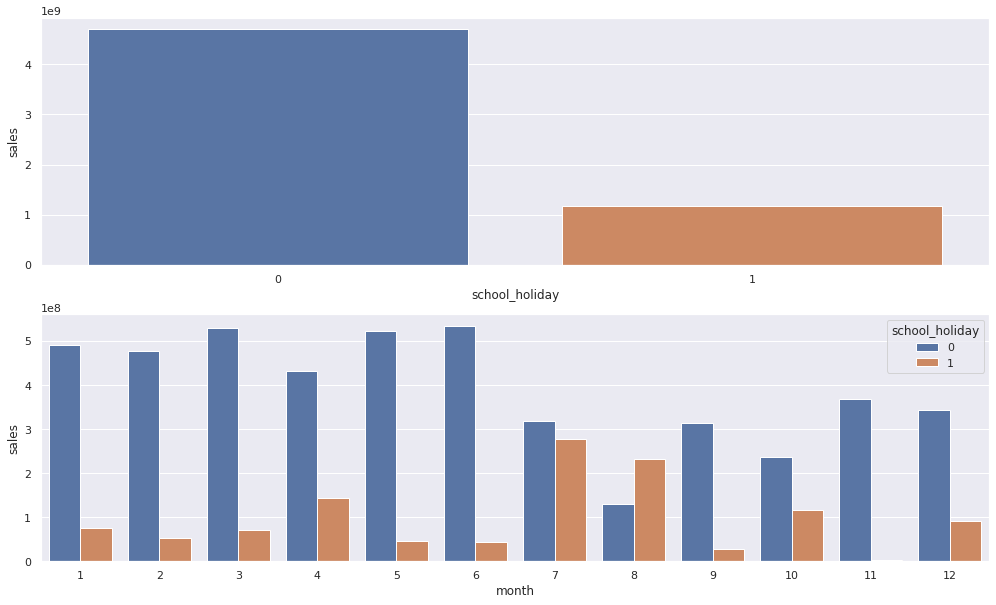

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



### 4.2.1 Resumo Analises


In [48]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Atributes

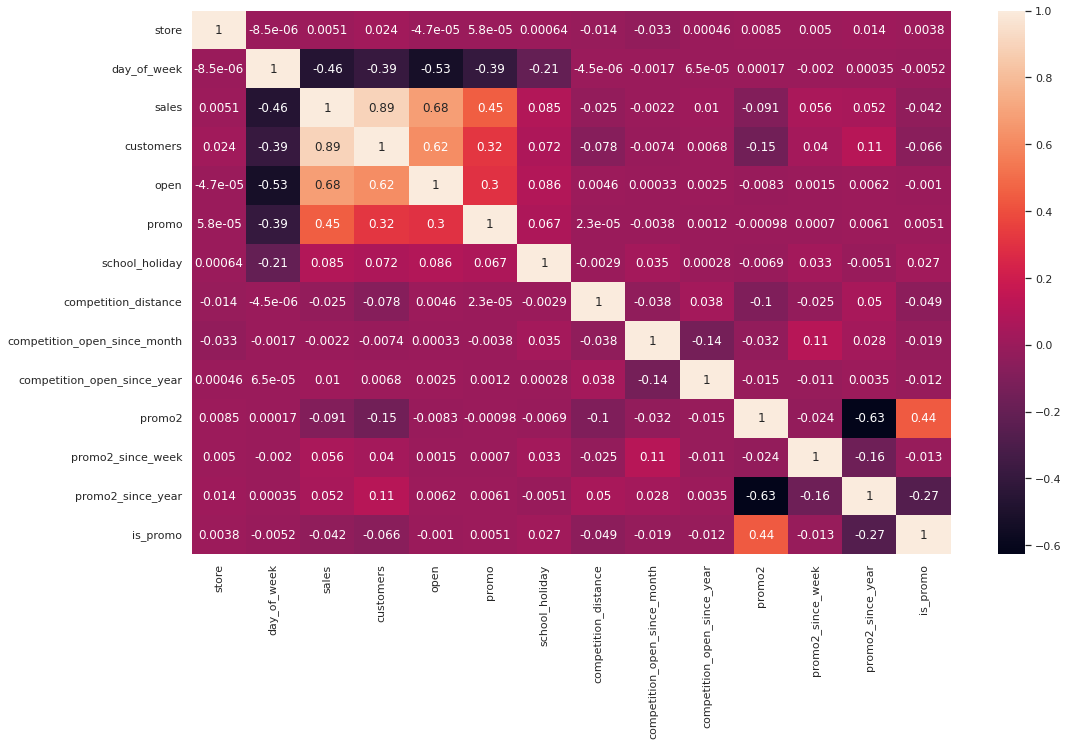

In [49]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap (correlation, annot=True);

### 4.3.2 Categorical Atributes

In [50]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
241499,530,5,2014-12-26,4601,0,christmas,1,a,extended,18160.0,...,0,2014,12,26,52,2014-51,2014-12-01,0,2014-12-22,0
241977,1099,5,2014-12-26,3719,0,christmas,1,a,extended,200.0,...,0,2014,12,26,52,2014-51,2013-04-01,21,2013-04-01,90
616339,530,4,2013-12-26,4712,0,christmas,1,a,extended,18160.0,...,0,2013,12,26,52,2013-51,2013-12-01,0,2013-12-23,0
616908,1099,4,2013-12-26,3929,0,christmas,1,a,extended,200.0,...,0,2013,12,26,52,2013-51,2013-04-01,8,2013-04-01,38


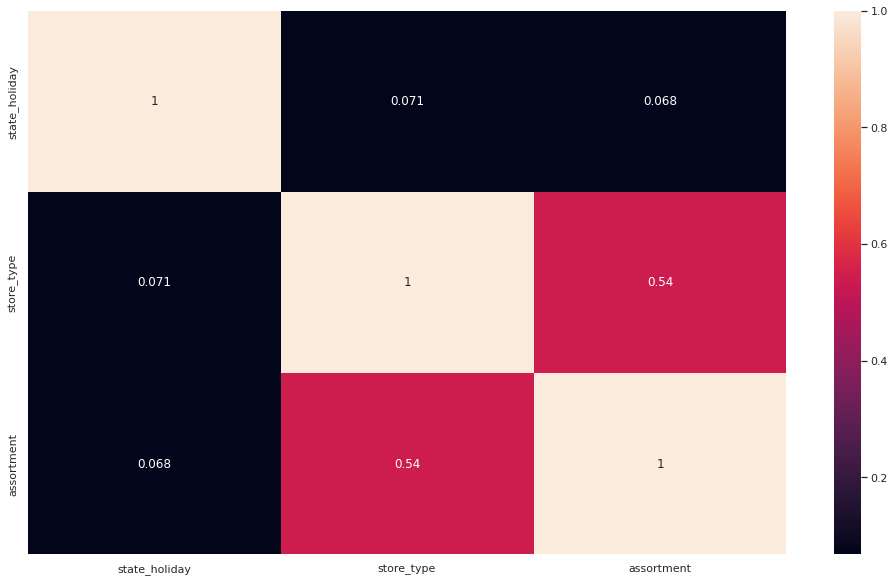

In [51]:
#only categorial data
a = df4.select_dtypes (include = 'object')

#calculate cramer
a1 = cramer_v (a['state_holiday'], a ['state_holiday'])
a2 = cramer_v (a['state_holiday'], a ['store_type'])
a3 = cramer_v (a['state_holiday'], a ['assortment'])

a4 = cramer_v (a['store_type'], a ['state_holiday'])
a5 = cramer_v (a['store_type'], a ['store_type'])
a6 = cramer_v (a['store_type'], a ['assortment'])

a7 = cramer_v (a['assortment'], a ['state_holiday'])
a8 = cramer_v (a['assortment'], a ['store_type'])
a9 = cramer_v (a['assortment'], a ['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d,annot=True);

# 5.0 Data Preparation

In [115]:
df5 = df4.copy()

## 5.1 Normalização 

## 5.2 Rescaling

In [116]:
rs = RobustScaler()  #Para features com outliers
mms = MinMaxScaler() #Para features com poucos ou sem outliers

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('parameter/ompetition_time_month_.scaler.pkl', 'wb'))
            
#promo_time_week

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms,open('parameter/promo_time_week_scaler.pkl', 'wb'))
           
            
#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('parameter/year_scaler.pkl', 'wb'))
           

## 5.3 Tranformação

### 5.3.1 Encoding

In [117]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns=['state_holiday'])

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2,'extended':3}


#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scarler.pk1','wb'))


### 5.3.2 Response Variable Transformation 

In [35]:
df5 ['sales'] = np.log1p(df5['sales'])


### 5.2.2 Nature Transformation

In [36]:
#month

df5['month_sin']  = df5['month'].apply (lambda x: np.sin(x*(2. *np.pi/12)))
df5['month_cos']  = df5['month'].apply (lambda x: np.cos(x*(2. *np.pi/12)))

#day

df5['day_sin']  = df5['day'].apply (lambda x: np.sin(x*(2. *np.pi/30)))
df5['day_cos']  = df5['day'].apply (lambda x: np.cos(x*(2. *np.pi/30)))

#week_of_year


df5['week_of_year_sin']  = df5['week_of_year'].apply (lambda x: np.sin(x*(2. *np.pi/52)))
df5['week_of_year_cos']  = df5['week_of_year'].apply (lambda x: np.cos(x*(2. *np.pi/52)))

#day_of_week


df5['day_of_week_sin']  = df5['day_of_week'].apply (lambda x: np.sin(x*(2. *np.pi/7)))
df5['day_of_week_cos']  = df5['day_of_week'].apply (lambda x: np.cos(x*(2. *np.pi/7)))


# 6.0 Feature Selection

In [37]:
df6 = df5.copy()

In [38]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.2 Split dataframe into training and test dataset

In [39]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week','promo_since', 'competition_since','year_week']
df6 = df6.drop (cols_drop, axis= 1 )



In [40]:
#training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset

X_test= df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date:{}'.format(X_train['date'].min()))
print('Training Max Date:{}'.format(X_train['date'].max()))

print('\nTest Min Date:{}'.format(X_test['date'].min()))
print('Test Max Date:{}'.format(X_test['date'].max()))

Training Min Date:2013-01-01 00:00:00
Training Max Date:2015-06-18 00:00:00

Test Min Date:2015-06-19 00:00:00
Test Max Date:2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [61]:
#training and test dataset for Boruta
#x_train_n = x_train.drop(['date','sales'], axis =1).values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta 
#boruta = BorutaPy(rf, n_estimators= 'auto', verbose=2, random_state=42  ).fit(x_train_n, y_train_n)


### 6.2.1 Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()

#best features
#x_train_fs = x_train.drop(['date','sales'], axis =1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#not select boruta
#cols_selected_not_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selected

In [41]:
cols_selected_boruta = ['store',
                       'promo',
                       'store_type',
                       'assortment',
                       'competition_distance',
                       'competition_open_since_month',
                       'competition_open_since_year',
                       'promo2',
                       'promo2_since_week',
                       'promo2_since_year',
                       'competition_time_month',
                       'promo_time_week',
                       'day_of_week_sin',
                       'day_of_week_cos',
                       'month_sin',
                       'month_cos',
                       'day_sin',
                       'day_cos',
                       'week_of_year_sin',
                       'week_of_year_cos']
                       
                       

# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Maching Learning Modelling

In [42]:
df7 = df6.copy()

## 7.1 Average Model

In [43]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation

x_training = X_train[ cols_selected_boruta_full ]

In [66]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge (aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

#perfomance

baseline_result = ml_error('Average Model', np.expm1 (y_test), np.expm1 (yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [45]:
#Error do modelo de linear regression e muito maior que erro de media
#Dados complexo para modelos lineares 
#model
lr = LinearRegression().fit(x_train, y_train)


#prediction
yhat_lr = lr.predict(x_test)

#perfomance
lr_result = ml_error('Lineal Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result




,Model Name,MAE,MAPE,RMSE
0,Lineal Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [46]:
lr_result_cv = cross_validation(x_training, 5,'Linear Regression ',lr,verbose=False)   
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [47]:
#model
lrr = Lasso (alpha= 0.01).fit(x_train, y_train)


#prediction
yhat_lrr = lrr.predict(x_test)

#perfomance
lrr_result = ml_error('Lineal Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lineal Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model -  Lasso - Cross Validation

In [48]:
lrr_result_cv = cross_validation(x_training, 5,'Lasso',lrr,verbose=False)   
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [ ]:
 #model
#rf = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)


#prediction
#yhat_rf = rf.predict(x_test)

#perfomance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

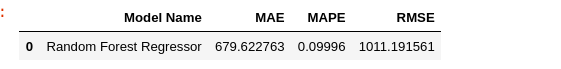

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation(x_training, 5,'Random Forest Regressor',rf,verbose=True)   
#rf_result_cv

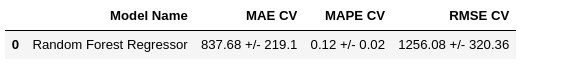

## 7.5 XGBoost Regressor

In [49]:
 #model
model_xgb = xgb.XGBRegressor (objective='reg:squarederror',
                              n_estimators=100, eta=0.01, 
                              max_depth = 10, 
                              subsample = 0.7, 
                              colsample_bytree=0.9).fit(x_train, y_train)


#prediction
yhat_xgb = model_xgb.predict(x_test)

#perfomance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.705545,0.949492,7330.988585


### 7.5.1 XGBoost Regressor - Cross Validation

In [50]:
xgb_result_cv = cross_validation(x_training, 5,'XGBoost Regressor',model_xgb,verbose=False)   
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.23 +/- 588.53,0.95 +/- 0.0,7715.24 +/- 689.33


## 7.6 Compare Model`s Performance 

### 7.6.1 Single Performance

In [ ]:
#modelling_result = pd.concat((baseline_result, lr_resul, lrr_result, rs_result, xgb_result))
#modelling_result.sort_value('RMSE')

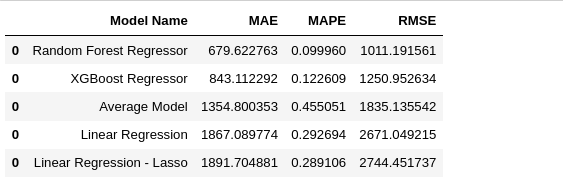

In [ ]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model,verbose=True)

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat((lr_resul_cv, lrr_result_cv, rs_result_xc, xgb_result_cv))
modelling_result_cv.sort_value('RMSE')

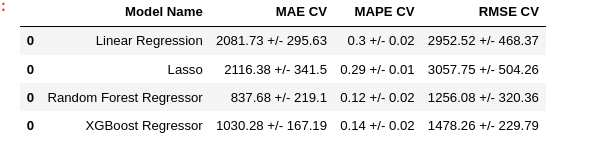

# 8.0 Hyperparameter Fine Tunning

## 8.1 Random Search

In [ ]:
#param = {
        #'n_estimators': [1500, 1700, 2500, 3000, 3500],
        #'eta': [0.01, 0.03],
        #'max_depth': [3, 5, 9],
        #'subsample': [0.1, 0.5, 0.7],
        #'colsample_bytree': [0.3, 0.7, 0.9],
        #'min_child_weight': [3, 8, 15]}
#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
    #chose values for paremeters randomly
    #hp = {k: random.sample(v,1)[0] for k, v in param.items()} 
    #print(hp)
    #model
    #model_xgb = xgb.XGBRegressor (objective='reg:squarederror',
                            #n_estimators=hp['n_estimators'], 
                              #eta=hp['eta'], 
                              #max_depth = hp['max_depth'], 
                              #subsample = hp['subsample'], 
                              #colsample_bytree=hp['colsample_bytree'],
                              #min_child_weight=hp['min_child_weight'])


    #perfomance
    #result = cross_validation(x_training, 2,'XGBoost Regressor', model_xgb, verbose=False)
    #final_result = pd.concat([final_result, result])

#final_result

## 8.2 Final Model 

In [54]:
param_tuned = {
        'n_estimators':3000 ,
        'eta': 0.03,
        'max_depth': 5 ,
        'subsample':  0.7 ,
        'colsample_bytree':0.7 ,
        'min_child_weight': 3}


In [55]:
#model
model_xgb_tuned = xgb.XGBRegressor (objective='reg:squarederror',
                               n_estimators=param_tuned['n_estimators'], 
                              eta=param_tuned['eta'], 
                              max_depth = param_tuned['max_depth'], 
                              subsample = param_tuned['subsample'], 
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
#predction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#perfomance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.975638,0.114861,1100.725148


In [58]:
mpe = mean_percentage_error (np.expm1(y_test),np.expm1(yhat_xgb_tuned))
mpe
#subestimando 

-0.01759492463883692

In [ ]:
-0.0035453341443739675

# 9.0 Traducao e Interpretacao do erro

In [61]:
df9 = X_test[ cols_selected_boruta_full]


#rescale
df9['sales'] = np.expm1 (df9['sales'])

df9['predictions'] = np.expm1 (yhat_xgb_tuned)

## 9.1 Business Performance

In [77]:
#sum predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE e MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})


df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})


#merge

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner',on='store')
df92 = pd.merge(df91,df9_aux3, how = 'inner', on='store')

#Scenerios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


df92.sample(4)


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
400,401,255447.828125,254375.125040,256520.531210,1072.703085,0.169479
736,737,225629.187500,224863.991858,226394.383142,765.195642,0.125625
652,653,217647.828125,217157.821329,218137.834921,490.006796,0.090288
778,779,251456.281250,250890.259660,252022.302840,566.021590,0.105811


In [79]:
df92.sort_values('MAPE', ascending = False).head()

#estrategias criar modelos expecificos para as lojas mais dificeis, colocar mais variavel, 

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108359.789062,104977.608681,111741.969444,3382.180381,0.602768
908,909,220300.078125,212395.141028,228205.015222,7904.937097,0.518675
875,876,194060.812500,189924.534753,198197.090247,4136.277747,0.337730
169,170,201541.687500,200194.421631,202888.953369,1347.265869,0.332923
748,749,206800.953125,205789.192000,207812.714250,1011.761125,0.283049


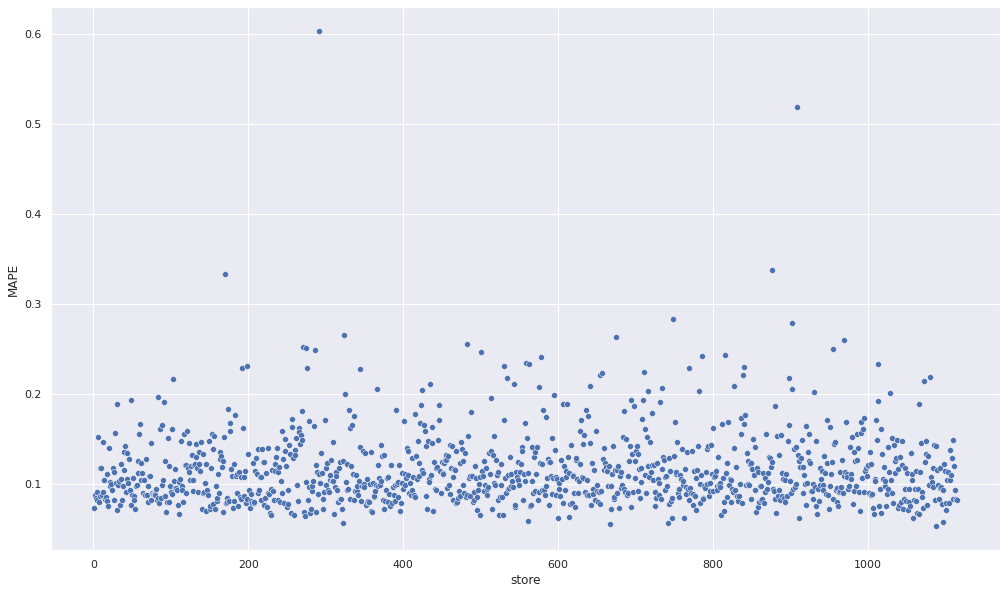

In [80]:
sns.scatterplot(x= 'store', y='MAPE', data= df92);

## 9.1 Total Performance

In [86]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x:np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenerios',0:'Values'})
df93['Values'] =df93['Values'].map('R${:,.2f}'.format)
df93


,Scenerios,Values
0,predictions,"R$286,435,584.00"
1,worst_scenario,"R$285,579,535.50"
2,best_scenario,"R$287,291,675.69"


## 9.2 Machine Learning Performance

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

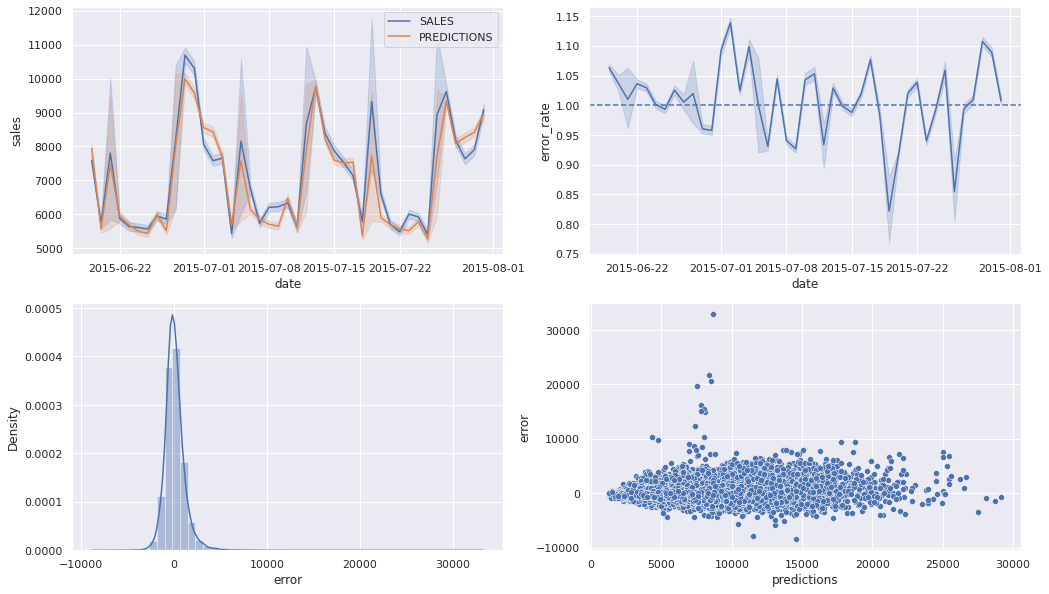

In [90]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y = 'sales', data=df9, label = 'SALES')
sns.lineplot(x='date', y = 'predictions', data=df9, label = 'PREDICTIONS')
#predicoes estao bem parecidos com as venda durantes 6 semanas


plt.subplot(2,2,2)
sns.lineplot(x='date', y = 'error_rate', data=df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])

# 10 Deploy Model to Production

In [39]:
#Save Trained Model
pickle.dump(model_xgb_tuned,open ('/home/andressasantos/Documents/comunidade_ds/ds_producao/model/model_rossmann.pkl', 'wb' ) )


NameError: name 'model_xgb_tuned' is not defined

## 10.1 Rossmann Class

In [60]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__( self ):
        self.home_path='/home/andressasantos/Documents/comunidade_ds/ds_producao/'
        self.competition_distance_scaler =   pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler =        pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler =                   pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.story_type_scaler =             pickle.load(open(self.home_path + 'parameter/store_type_scaler.pk1','rb'))
    
    def data_cleaning (self,df1):
      
        ## 1.1 Rename Columns
        cols_old= ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
                  'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                  'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore (x)

        cols_new = list (map(snakecase, cols_old))

        #rename
        df1.columns = cols_new


        ## 1.3 Data Types

        df1['date']= pd.to_datetime (df1['date'])

        ## 1.5 Fillout NA

        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

        #competition_open_since_year  

        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 


        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year  

        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        #promo_interval   
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10: 'Oct', 11: 'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)


        df1['is_promo']  = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                                      if x['month_map'] in x['promo_interval']. split (',') else 0, axis=1)

        ## 1.6 Changes Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


        return df1 


    def feature_engineering(self,df2):

        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year_week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        #competition_since
        df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis = 1)
        df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

        #promo_since
        df2 ['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2 ['promo_since'].apply (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))

        df2['promo_time_week'] = (((df2['date'] - df2['promo_since'])/7). apply (lambda x: x.days).astype(int))

        #assortment
        df2['assortment'] = df2['assortment'].apply (lambda x: 'basic'if x== 'a' else 'extra' if x== 'b' else 'extended')


        #state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday'if x== 'a' else 'easter_holiday' if x== 'b' else 'christmas'if x== 'c' else 'regular_day')

        # 3.1 Filtragem das linhas

        df2 = df2 [df2['open'] !=0 ]

        ## 3.2 Filtragem das colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop (cols_drop, axis=1)
        return df2


    def data_preparation(self, df5):
    
         ## 5.2 Rescaling
         #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)


        #competition_time_month

        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
       

        #promo_time_week

        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
       

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1 Encoding

        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns=['state_holiday'])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict )

        #store_type - Label Encoding
        df5['store_type'] = self.story_type_scaler.fit_transform(df5['store_type'])


        ### 5.2.2 Nature Transformation

        #month

        df5['month_sin']  = df5['month'].apply (lambda x: np.sin(x*(2. *np.pi/12)))
        df5['month_cos']  = df5['month'].apply (lambda x: np.cos(x*(2. *np.pi/12)))

        #day

        df5['day_sin']  = df5['day'].apply (lambda x: np.sin(x*(2. *np.pi/30)))
        df5['day_cos']  = df5['day'].apply (lambda x: np.cos(x*(2. *np.pi/30)))

        #week_of_year


        df5['week_of_year_sin']  = df5['week_of_year'].apply (lambda x: np.sin(x*(2. *np.pi/52)))
        df5['week_of_year_cos']  = df5['week_of_year'].apply (lambda x: np.cos(x*(2. *np.pi/52)))

        #day_of_week


        df5['day_of_week_sin']  = df5['day_of_week'].apply (lambda x: np.sin(x*(2. *np.pi/7)))
        df5['day_of_week_cos']  = df5['day_of_week'].apply (lambda x: np.cos(x*(2. *np.pi/7)))
        
        
        cols_selected =     ['store',
                             'promo',
                                       'store_type',
                                       'assortment',
                                       'competition_distance',
                                       'competition_open_since_month',
                                       'competition_open_since_year',
                                       'promo2',
                                       'promo2_since_week',
                                       'promo2_since_year',
                                       'competition_time_month',
                                       'promo_time_week',
                                       'day_of_week_sin',
                                       'day_of_week_cos',
                                       'month_sin',
                                       'month_cos',
                                       'day_sin',
                                       'day_cos',
                                       'week_of_year_sin',
                                       'week_of_year_cos']
                       
        
        return df5[cols_selected]

    def get_prediction (self,model,original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into origin data
        original_data['prediction'] = np.expm1 (pred)
    
        return original_data.to_json(orient='records', date_format='iso' )

## 10.2 API Handler

In [32]:
import pickle
from flask import Flask, request, Response
import pandas as pd 
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('/home/andressasantos/Documents/comunidade_ds/ds_producao/model/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask( __name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #Multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
         #Instantiate Rossmann class
        pipeline = Rossmann()
        #Data cleaning 
        df1 = pipeline.data_cleaning(test_raw)
        #Feature engineering
        df2 = pipeline.feature_engineering(df1)      
        #Data preparation
        df3 = pipeline.data_preparation(df2)
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        return df_response
            
            
    else:
        return Response('{}', status = 200, mimetype='application/jason')
        

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API tester

In [33]:
#loading test dataset
df10 = pd.read_csv('/home/andressasantos/Documents/comunidade_ds/ds_producao/data/test.csv')

In [34]:
#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on = 'Store')
#choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

#remove closed days
df_test = df_test[df_test['Open'] !=0]
df_test = df_test[-df_test['Open'].isnull()]
df_test= df_test.drop('Id', axis=1)

#convert DataFrama em json
data = json.dumps (df_test.to_dict(orient='reconds'))

#API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-prection-model.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'} 
data = data

r = requests.post(url,data = data, headers = header)
print('Status Code {} '.format(r.status_code))

Status Code 200 


In [35]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [36]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()


for i in range (len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i, 'prediction']))

Store Number 20 will sell R$313,819.52 in the next 6 weeks
Store Number 22 will sell R$209,420.74 in the next 6 weeks
Store Number 23 will sell R$240,153.31 in the next 6 weeks
